# Extraction & EDA (sans scraping)
## Analyse comparative Airbnb : Madrid vs Barcelona

**Objectif :** comparer le marché Airbnb entre Madrid et Barcelona (prix, typologies, disponibilité via `availability_365`), et valider statistiquement la différence de prix.

**Source :** Inside Airbnb  
**Date de téléchargement :** 02/11/2026  
**Fichier utilisé :** `data/processed/listings_clean.csv`


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le dataset propre (produit par 01_listings_merge.ipynb)
df = pd.read_csv("../data/processed/listings_clean.csv")

print("✅ Shape :", df.shape)
df.head()


✅ Shape : (33887, 19)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,city
0,30320,Apartamentos Dana Sol,130907,Danuta Weronika,Centro,Sol,40.41476,-3.70418,Entire home/apt,157.0,5,173,2025-08-27,0.93,17,342,1,NaN,Madrid
1,40916,Apartasol Apartamentos Dana,130907,Danuta Weronika,Centro,Universidad,40.42247,-3.70577,Entire home/apt,143.0,5,53,2025-09-11,0.29,17,341,4,NaN,Madrid
2,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,Arturo,Centro,Justicia,40.41884,-3.69655,Private room,65.0,1,249,2025-09-05,2.78,3,299,41,NaN,Madrid
3,70073,Adorable Apartment Malasaña-Gran Via,353738,Raquel,Centro,Universidad,40.42252,-3.70250,Entire home/apt,116.0,30,36,2025-04-27,0.21,4,305,1,NaN,Madrid
4,70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",353738,Raquel,Centro,Universidad,40.42252,-3.70250,Entire home/apt,79.0,30,31,2025-05-02,0.18,4,317,2,NaN,Madrid


## 1) Qualité des données (contrôles rapides)


In [2]:
df.info()
df.isnull().sum().sort_values(ascending=False).head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33887 entries, 0 to 33886
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33887 non-null  int64  
 1   name                            33887 non-null  object 
 2   host_id                         33887 non-null  int64  
 3   host_name                       33791 non-null  object 
 4   neighbourhood_group             33887 non-null  object 
 5   neighbourhood                   33887 non-null  object 
 6   latitude                        33887 non-null  float64
 7   longitude                       33887 non-null  float64
 8   room_type                       33887 non-null  object 
 9   price                           33887 non-null  float64
 10  minimum_nights                  33887 non-null  int64  
 11  number_of_reviews               33887 non-null  int64  
 12  last_review                     

license                13958
last_review             6437
reviews_per_month       6437
host_name                 96
host_id                    0
id                         0
name                       0
longitude                  0
neighbourhood_group        0
neighbourhood              0
latitude                   0
minimum_nights             0
price                      0
room_type                  0
number_of_reviews          0
dtype: int64

## 2) Statistiques descriptives globales


In [3]:
df["price"].describe()


count    33887.000000
mean       144.862366
std        115.639802
min          8.000000
25%         69.500000
50%        115.000000
75%        184.000000
max        974.000000
Name: price, dtype: float64

## 3) KPI par ville


In [4]:
kpi_city = df.groupby("city")["price"].agg(["count","mean","median","min","max"])
kpi_city


,count,mean,median,min,max
city,,,,,
Barcelona,15054,158.255812,129.0,9.0,974.0
Madrid,18833,134.156428,110.0,8.0,971.0


## 4) Visualisations — prix


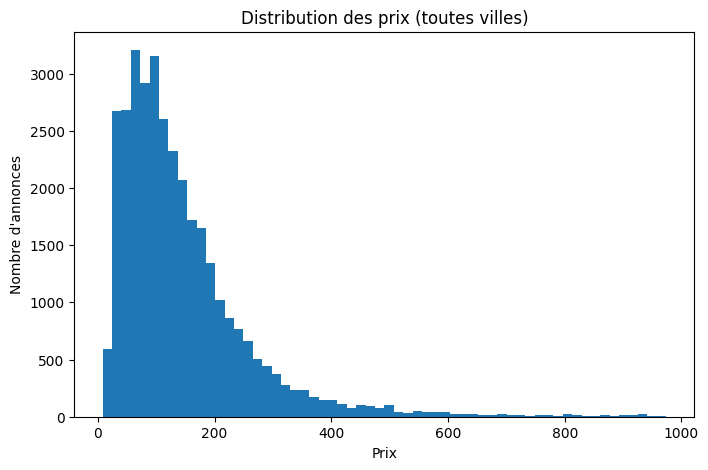

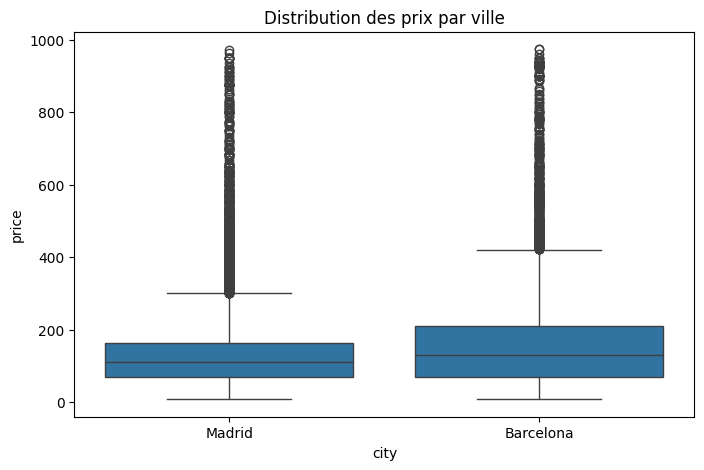

In [5]:
plt.figure(figsize=(8,5))
plt.hist(df["price"], bins=60)
plt.title("Distribution des prix (toutes villes)")
plt.xlabel("Prix")
plt.ylabel("Nombre d'annonces")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="city", y="price")
plt.title("Distribution des prix par ville")
plt.show()


## 5) Prix par type de logement (`room_type`)


In [6]:
df.groupby(["city","room_type"])["price"].agg(["count","mean","median"]).sort_values(("mean"), ascending=False)


count        mean  median
city      room_type                                 
Barcelona Hotel room          50  223.940000   202.0
          Entire home/apt  10288  191.604005   167.0
Madrid    Entire home/apt  13561  157.632402   129.0
          Hotel room          41  151.097561   152.0
Barcelona Private room      4610   85.007809    62.0
          Shared room        106   76.207547    44.0
Madrid    Private room      5084   73.937057    50.0
          Shared room        147   46.421769    30.0

## 6) Disponibilité (`availability_365`) par ville


In [7]:
df.groupby("city")["availability_365"].describe()


,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Barcelona,15054.0,227.255812,108.985524,0.0,132.0,256.0,324.0,365.0
Madrid,18833.0,212.922636,115.671075,0.0,98.0,245.0,318.0,365.0


## 7) Test statistique — T-test (prix Madrid vs Barcelona)
Hypothèses :
- **H0** : pas de différence significative de prix moyen
- **H1** : différence significative


In [8]:
from scipy import stats

madrid_prices = df.loc[df["city"] == "Madrid", "price"]
barcelona_prices = df.loc[df["city"] == "Barcelona", "price"]

t_stat, p_value = stats.ttest_ind(madrid_prices, barcelona_prices, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -18.83235357442685
P-value: 1.1812903978953072e-78


### Conclusion du test statistique

La p-value obtenue est extrêmement faible (p < 0.05).

Nous rejetons l’hypothèse H0.

Il existe une différence statistiquement significative entre les prix moyens des logements à Madrid et à Barcelone.

Barcelone présente des prix moyens plus élevés que Madrid.

Recommandation métier :
Pour un investisseur Airbnb, Barcelone offre un positionnement plus premium.
Pour un budget modéré, Madrid présente plus d’opportunités accessibles.

